In [1]:
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from scipy.stats import chi2_contingency

In [2]:
end = dt.datetime(2023,10,1)
start = dt.datetime(2000,1,1)
start, end

(datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2023, 10, 1, 0, 0))

In [3]:
sp500url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
data_table = pd.read_html(sp500url)
data_table[0].head()


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
tickers = data_table[0]['Symbol'].tolist()
snp_prices = yf.download(tickers, start='2000-01-01', end='2022-01-05')['Adj Close']

[*********************100%%**********************]  503 of 503 completed


6 Failed downloads:
['GEHC', 'KVUE', 'CEG', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1641358800")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-01-01 -> 2022-01-05)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


[*********************100%%**********************]  503 of 503 completed


6 Failed downloads:
['GEHC', 'KVUE', 'CEG', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1641358800")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-01-01 -> 2022-01-05)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


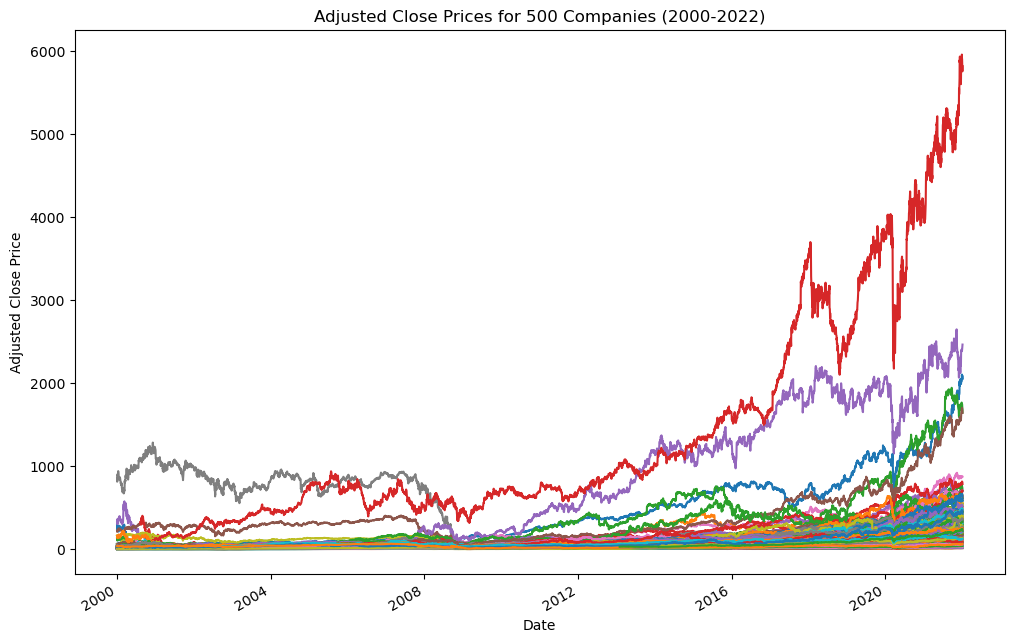

In [5]:
import matplotlib.pyplot as plt

tickers = data_table[0]['Symbol'].tolist()

snp_prices = yf.download(tickers, start='2000-01-01', end='2022-01-05')['Adj Close']

# Plot the adjusted close prices for each ticker
snp_prices.plot(figsize=(12, 8), legend=False)
plt.title('Adjusted Close Prices for 500 Companies (2000-2022)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()


In [6]:
import requests
import json
from tqdm import tqdm
from ratelimit import limits, sleep_and_retry

api_key = '837a05cca328ffa0890170f4daddb4f267ce37c2aa6f6a13e000'

@sleep_and_retry
@limits(calls=10, period=60)
def call_api(symbol):
    response = requests.get(f"https://api.datajockey.io/v0/company/financials?apikey={api_key}&ticker={symbol}&period=Q&filetype=json")

    if response.status_code != 200:
        raise Exception('API response: {} and {}'.format(response.status_code, response.json()))
    return response.json()


def build_fundamentals_data(df):
  results = []
  exception_statements = []
  for symbol in tqdm(df):
      try: 
          result = call_api(symbol)
          results.append(result)
      except Exception as e:
          exception_statements.append(f"Failed for symbol {symbol} with message: {str(e)}")

  for statement in exception_statements:
      print(statement)

  with open('fundamentals_results.json', 'w') as output_file:
        json.dump(results, output_file)


In [7]:
build_fundamentals_data(tickers)

  0%|          | 0/503 [00:00<?, ?it/s]

100%|██████████| 503/503 [50:01<00:00,  5.97s/it]  


Failed for symbol GOOG with message: API response: 404 and {'error': 'The data for this ticker does not exist'}
Failed for symbol BRK.B with message: API response: 404 and {'error': 'The data for this ticker does not exist'}
Failed for symbol BF.B with message: API response: 404 and {'error': 'The data for this ticker does not exist'}
Failed for symbol COR with message: API response: 404 and {'error': 'The data for this ticker does not exist'}
Failed for symbol CEG with message: API response: 404 and {'error': 'The data for this ticker does not exist'}
Failed for symbol EG with message: API response: 404 and {'error': 'The data for this ticker does not exist'}
Failed for symbol FI with message: API response: 404 and {'error': 'The data for this ticker does not exist'}
Failed for symbol FOX with message: API response: 404 and {'error': 'The data for this ticker does not exist'}
Failed for symbol NWS with message: API response: 404 and {'error': 'The data for this ticker does not exist'}

In [8]:
import json

with open('fundamentals_results.json') as f:
    financial_records = json.load(f)

In [9]:
from tqdm import tqdm

record_set = set(financial_records[0]["financial_data"]["quarterly"].keys())
df = pd.DataFrame(columns=["ticker", "currency", "quarter", *record_set])


for record in tqdm(financial_records):
    start_quarter, end_quarter = None, None

    for variable in record_set:
        record_keys = list(record["financial_data"]["quarterly"][variable].keys())

        if len(record_keys) != 0:
            smallest_quarter_in_record = min(record_keys)
            biggest_quarter_in_record = max(record_keys)
            start_quarter = min(start_quarter, smallest_quarter_in_record) if start_quarter is not None else smallest_quarter_in_record
            end_quarter = max(end_quarter, biggest_quarter_in_record) if end_quarter is not None else biggest_quarter_in_record

    quarter_list = [start_quarter]
    start_quarter = [int(entry) for entry in start_quarter.split("Q")]
    running_quarter = start_quarter
    pres_quarter = None
    while pres_quarter != end_quarter:
        running_quarter[0] = running_quarter[0] + (running_quarter[1])//4
        running_quarter[1] = running_quarter[1]%4 + 1
        pres_quarter = f"{running_quarter[0]}Q{running_quarter[1]}"
        quarter_list.append(pres_quarter)

    for quarter in quarter_list:
        df.loc[len(df.index)] = [record['company_info']['ticker'], record['currency'], quarter, *[record["financial_data"]["quarterly"][variable].get(quarter, None) for variable in record_set]]

df

100%|██████████| 492/492 [21:11<00:00,  2.58s/it]


,ticker,currency,quarter,prepaid_expenses,total_liabilities,inventory,operating_cash_flow,pre_tax_income,total_non_current_liabilities,property_plant_and_equipment_net,...,other_assets_noncurrent,goodwill,shares_outstanding_diluted,total_assets,research_development_expense,cash_on_hand,shares_outstanding_basic,financing_cash_flow,intangible_assets_excluding_goodwill,revenue
0,MMM,USD,2006Q4,None,None,None,None,None,None,None,...,None,None,None,None,None,1447000000,None,None,None,None
1,MMM,USD,2007Q1,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,MMM,USD,2007Q2,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,MMM,USD,2007Q3,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,MMM,USD,2007Q4,None,None,None,None,None,None,None,...,None,None,None,None,None,1896000000,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30379,ZTS,USD,2022Q2,None,9190000000,2205000000,None,670000000,233000000,2559000000,...,147000000,2720000000,471500000,13770000000,None,2652000000,470000000,None,1390000000,2052000000
30380,ZTS,USD,2022Q3,None,9012000000,2303000000,None,667000000,239000000,2623000000,...,161000000,2692000000,469100000,13674000000,None,2507000000,467800000,None,1319000000,2002000000
30381,ZTS,USD,2022Q4,None,10522000000,2345000000,None,592000000,217000000,2753000000,...,147000000,2746000000,470385000,14925000000,None,3581000000,468891000,None,1380000000,2040000000
30382,ZTS,USD,2023Q1,None,9263000000,2563000000,549000000,697000000,216000000,2913000000,...,143000000,2738000000,464600000,13754000000,None,2109000000,463500000,-1802000000,1314000000,2000000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30384 entries, 0 to 30383
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ticker                                  30384 non-null  object
 1   currency                                30384 non-null  object
 2   quarter                                 30384 non-null  object
 3   prepaid_expenses                        8145 non-null   object
 4   total_liabilities                       17181 non-null  object
 5   inventory                               15065 non-null  object
 6   operating_cash_flow                     7557 non-null   object
 7   pre_tax_income                          23773 non-null  object
 8   total_non_current_liabilities           19427 non-null  object
 9   property_plant_and_equipment_net        23074 non-null  object
 10  net_income                              26462 non-null  object
 11  to

In [11]:
df.info()
subset = df[['ticker', 'quarter', 'inventory', 'revenue', 'net_income', 'total_assets', 'total_liabilities']]
print(subset.head())
print(subset.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30384 entries, 0 to 30383
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ticker                                  30384 non-null  object
 1   currency                                30384 non-null  object
 2   quarter                                 30384 non-null  object
 3   prepaid_expenses                        8145 non-null   object
 4   total_liabilities                       17181 non-null  object
 5   inventory                               15065 non-null  object
 6   operating_cash_flow                     7557 non-null   object
 7   pre_tax_income                          23773 non-null  object
 8   total_non_current_liabilities           19427 non-null  object
 9   property_plant_and_equipment_net        23074 non-null  object
 10  net_income                              26462 non-null  object
 11  to

In [12]:
dismissal_with_tickers = pd.read_csv('merged.csv') 
dismissal_updated = dismissal_with_tickers[["year","ceo_dismissal","The fiscal year during which the CEO exited - for clarity","leftofc","Symbol","Sector"]]
dismissal_updated.head()
dismissal_updated.info() 
dismissal_updated.describe()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 6 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   year                                                       598 non-null    int64 
 1   ceo_dismissal                                              598 non-null    int64 
 2   The fiscal year during which the CEO exited - for clarity  598 non-null    int64 
 3   leftofc                                                    598 non-null    object
 4   Symbol                                                     598 non-null    object
 5   Sector                                                     598 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


,year,ceo_dismissal,The fiscal year during which the CEO exited - for clarity
count,598.000000,598.000000,598.000000
mean,2005.963211,0.195652,2006.571906
std,7.638744,0.397034,7.665582
min,1992.000000,0.000000,1992.000000
25%,1999.000000,0.000000,2000.000000
50%,2006.000000,0.000000,2006.000000
75%,2013.000000,0.000000,2013.000000
max,2019.000000,1.000000,2021.000000


In [13]:
dismissal_updated['leftofc'] = pd.to_datetime(dismissal_updated['leftofc'])
dismissal_updated.loc[:, 'dismissal_year'] = dismissal_updated['leftofc'].dt.year
total_dismissals_by_sector = dismissal_updated.groupby('Sector')['ceo_dismissal'].sum().reset_index()
print(total_dismissals_by_sector)


                        Sector  ceo_dismissal
0       Consumer Discretionary             25
1             Consumer Staples             18
2                       Energy              4
3                   Financials             15
4                  Health Care             13
5                  Industrials             13
6       Information Technology             12
7                    Materials              4
8                  Real Estate              3
9   Telecommunication Services              0
10                   Utilities             10


/var/folders/ws/y4s13dw95dd92p32p0mgjt600000gn/T/ipykernel_48921/3117195630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dismissal_updated['leftofc'] = pd.to_datetime(dismissal_updated['leftofc'])
/var/folders/ws/y4s13dw95dd92p32p0mgjt600000gn/T/ipykernel_48921/3117195630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dismissal_updated.loc[:, 'dismissal_year'] = dismissal_updated['leftofc'].dt.year


In [14]:
dismissal_updated['leftofc'] = pd.to_datetime(dismissal_updated['leftofc'])
dismissal_updated['dismissal_year'] = dismissal_updated['leftofc'].dt.year

contingency_table = pd.crosstab(dismissal_updated['Sector'], dismissal_updated['ceo_dismissal'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Contingency Table:")
print(contingency_table)
print("\nChi-square Test Result:")
print(f"Chi2: {chi2}")
print(f"P-value: {p}")

alpha = 0.05
if p < alpha:
    print("\nThe dismissal is statistically significant across different sectors.")
else:
    print("\nThe dismissal is not statistically significant across different sectors.")


/var/folders/ws/y4s13dw95dd92p32p0mgjt600000gn/T/ipykernel_48921/3613367208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dismissal_updated['leftofc'] = pd.to_datetime(dismissal_updated['leftofc'])
/var/folders/ws/y4s13dw95dd92p32p0mgjt600000gn/T/ipykernel_48921/3613367208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dismissal_updated['dismissal_year'] = dismissal_updated['leftofc'].dt.year


Contingency Table:
ceo_dismissal                0   1
Sector                            
Consumer Discretionary      71  25
Consumer Staples            53  18
Energy                      28   4
Financials                  60  15
Health Care                 59  13
Industrials                 75  13
Information Technology      37  12
Materials                   37   4
Real Estate                  9   3
Telecommunication Services   1   0
Utilities                   51  10

Chi-square Test Result:
Chi2: 10.602450208096847
P-value: 0.38931719942737253

The dismissal is not statistically significant across different sectors.


In [15]:
dismissal_updated['leftofc'] = pd.to_datetime(dismissal_updated['leftofc'])
dismissal_updated['dismissal_year'] = dismissal_updated['leftofc'].dt.year
dismissal_updated['is_special_year'] = dismissal_updated['dismissal_year'].isin([2000, 2001, 2007, 2008, 2009])

contingency_table = pd.crosstab(dismissal_updated['is_special_year'], dismissal_updated['ceo_dismissal'])

chi2, p, _, _ = chi2_contingency(contingency_table)

print("Contingency Table:")
print(contingency_table)
print("\nChi-square Test Result:")
print(f"Chi2: {chi2}")
print(f"P-value: {p}")

alpha = 0.05
if p < alpha:
    print("\nThe dismissal is statistically significant in the specified years.")
else:
    print("\nThe dismissal is not statistically significant in the specified years.")


Contingency Table:
ceo_dismissal      0   1
is_special_year         
False            380  91
True             101  26

Chi-square Test Result:
Chi2: 0.027019345942060357
P-value: 0.8694354513602165

The dismissal is not statistically significant in the specified years.


/var/folders/ws/y4s13dw95dd92p32p0mgjt600000gn/T/ipykernel_48921/3355454497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dismissal_updated['leftofc'] = pd.to_datetime(dismissal_updated['leftofc'])
/var/folders/ws/y4s13dw95dd92p32p0mgjt600000gn/T/ipykernel_48921/3355454497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dismissal_updated['dismissal_year'] = dismissal_updated['leftofc'].dt.year
/var/folders/ws/y4s13dw95dd92p32p0mgjt600000gn/T/ipykernel_48921/3355454497.py:3: SettingWithCopyWarning:

/var/folders/ws/y4s13dw95dd92p32p0mgjt600000gn/T/ipykernel_48921/3925914034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dismissal_updated['Dismissal Year'] = pd.to_datetime(dismissal_updated['leftofc']).dt.year


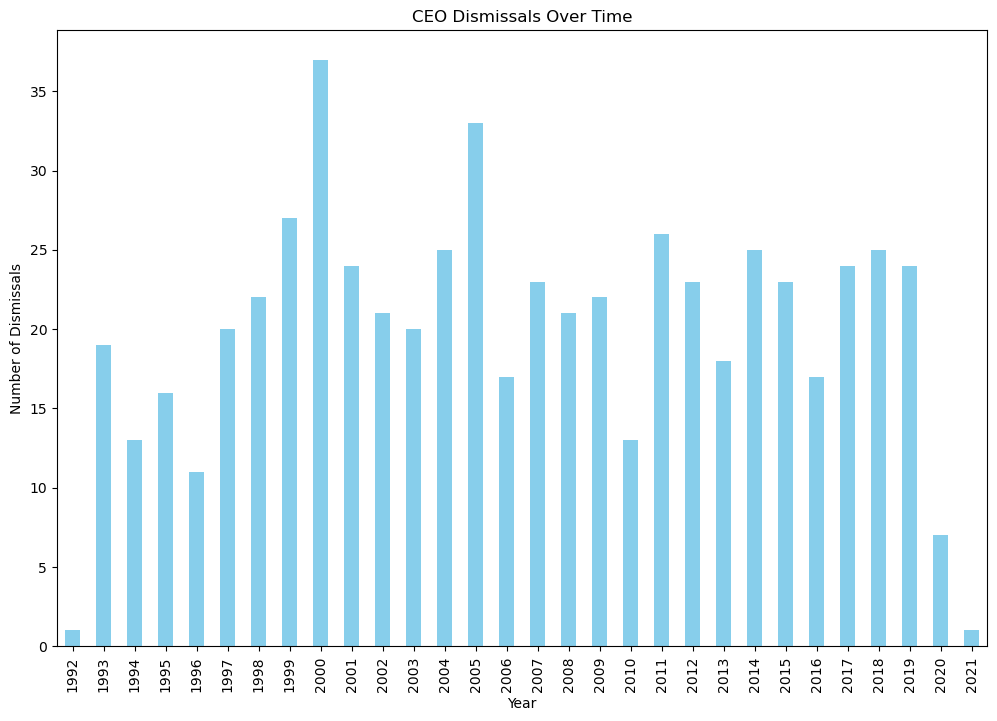

In [16]:
dismissal_updated['Dismissal Year'] = pd.to_datetime(dismissal_updated['leftofc']).dt.year

# Plot time trends for CEO dismissals
time_trends = dismissal_updated['Dismissal Year'].value_counts().sort_index()
plt.figure(figsize=(12, 8))
time_trends.plot(kind='bar', color='skyblue')
plt.title('CEO Dismissals Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Dismissals')
plt.show()


In [17]:
dismissal_updated.info()
dismissal_updated.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 9 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   year                                                       598 non-null    int64         
 1   ceo_dismissal                                              598 non-null    int64         
 2   The fiscal year during which the CEO exited - for clarity  598 non-null    int64         
 3   leftofc                                                    598 non-null    datetime64[ns]
 4   Symbol                                                     598 non-null    object        
 5   Sector                                                     598 non-null    object        
 6   dismissal_year                                             598 non-null    int64         
 7   is_special_year                     

,year,ceo_dismissal,The fiscal year during which the CEO exited - for clarity,leftofc,Symbol,Sector,dismissal_year,is_special_year,Dismissal Year
0,1998,0,1998,1998-12-31,ABT,Health Care,1998,False,1998
1,2019,0,2020,2020-03-31,ABT,Health Care,2020,False,2020
2,2001,0,2002,2002-04-25,AMD,Information Technology,2002,False,2002
3,2008,1,2008,2008-07-17,AMD,Information Technology,2008,True,2008
4,2010,1,2011,2011-01-10,AMD,Information Technology,2011,False,2011
5,2011,0,2011,2011-08-01,AMD,Information Technology,2011,False,2011
6,2014,0,2014,2014-10-08,AMD,Information Technology,2014,False,2014
7,1997,0,1997,1997-07-28,AET,Health Care,1997,False,1997
8,1999,1,2000,2000-02-25,AET,Health Care,2000,True,2000
9,2000,0,2000,2000-09-15,AET,Health Care,2000,True,2000


In [18]:
merged_data = pd.merge(dismissal_updated, df, how='inner', left_on=['Symbol'], right_on=['ticker'])
#merged_data.info()
#merged_data.head(100)
#merged_data.tail(100)   
# Number of unique values in the 'Symbol' column
unique_symbols = dismissal_with_tickers['Symbol'].nunique()
print(f"Number of unique values in 'Symbol' column: {unique_symbols}")

# Number of unique values in the 'ticker' column
unique_tickers = df['ticker'].nunique()
print(f"Number of unique values in 'ticker' column: {unique_tickers}")

Number of unique values in 'Symbol' column: 198
Number of unique values in 'ticker' column: 492


In [22]:
df.to_csv('financials.csv', index=False)
df.head(10)



,ticker,currency,quarter,prepaid_expenses,total_liabilities,inventory,operating_cash_flow,pre_tax_income,total_non_current_liabilities,property_plant_and_equipment_net,...,other_assets_noncurrent,goodwill,shares_outstanding_diluted,total_assets,research_development_expense,cash_on_hand,shares_outstanding_basic,financing_cash_flow,intangible_assets_excluding_goodwill,revenue
0,MMM,USD,2006Q4,None,None,None,None,None,None,None,...,None,None,None,None,None,1447000000,None,None,None,None
1,MMM,USD,2007Q1,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,MMM,USD,2007Q2,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,MMM,USD,2007Q3,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,MMM,USD,2007Q4,None,None,None,None,None,None,None,...,None,None,None,None,None,1896000000,None,None,None,None
5,MMM,USD,2008Q1,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,MMM,USD,2008Q2,None,None,None,None,1416000000,None,None,...,None,None,712000000,None,None,1547000000,702100000,None,None,6739000000
7,MMM,USD,2008Q3,None,None,None,None,1489000000,None,None,...,None,None,703100000,None,None,2240000000,695500000,None,None,6558000000
8,MMM,USD,2008Q4,None,15489000000,3013000000,None,None,1637000000,6886000000,...,1659000000,5753000000,None,25793000000,None,1849000000,None,None,1398000000,None
9,MMM,USD,2009Q1,None,None,None,695000000,759000000,None,None,...,None,None,695900000,None,None,1632000000,693500000,-907000000,None,5089000000
